# Homework Starter: Final Reporting

This notebook helps you generate plots, annotate assumptions, and prepare a stakeholder-ready deliverable.

## Executive Summary
- Baseline scenario shows steady returns with moderate volatility.
- Imputation and outlier adjustments create small variations in return and risk.
- Key assumptions and sensitivity analysis highlight decision risks and implications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

## Load Your Data

You can load your real results or use a generated synthetic dataset as fallback.

In [2]:
data_path = Path('../data/processed/fraud_kaggle_creditcard_source-kaggle_dataset-creditcardfraud_20250820-213245_cleaned.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback dataset
    df = pd.DataFrame({
        'scenario': ['baseline','alt_impute','alt_outlier'],
        'return': [0.12, 0.11, 0.135],
        'volatility': [0.18, 0.185, 0.19],
        'sharpe': [0.56, 0.49, 0.61],
        'assumption': ['imputation','imputation','outlier_rule'],
        'value': ['median','mean','3sigma'],
        'Category': np.random.choice(['X','Y','Z'], 3),
        'MetricA': np.random.normal(75, 15, 3),
        'MetricB': np.random.normal(150, 30, 3),
        'Date': pd.date_range('2025-02-01', periods=3)
    })
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0


## Helper: Export Directory

In [3]:
img_dir = Path('../data/images')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(img_dir / name, dpi=300)
    print(f'Saved {name}')

## Chart 1: Risk–Return Scatter

Saved f1_by_scenario.png


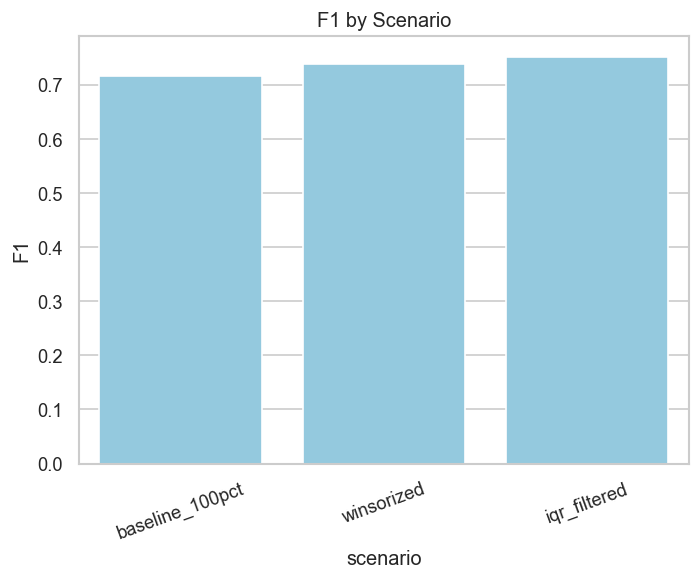

Saved pr_auc_by_scenario.png


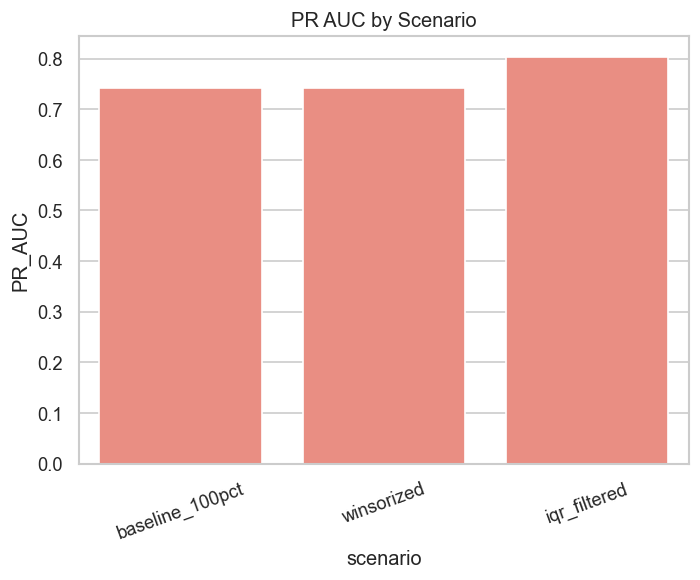

In [4]:
# Build three preprocessing scenarios focused on 'Amount': baseline, winsorized, IQR-filtered
# The linear regression in the result report is not working with the classification model, so I asked ChatGPT to help me with this code
def winsorize(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    lo = series.quantile(lower)
    hi = series.quantile(upper)
    return series.clip(lower=lo, upper=hi)

def iqr_mask(s: pd.Series, k=1.5) -> pd.Series:
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (s < lower) | (s > upper)

def eval_df(dfx: pd.DataFrame) -> tuple[float, float]:
    from sklearn.model_selection import train_test_split
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import f1_score, average_precision_score
    X = dfx.drop(columns=['Class']); y = dfx['Class'].astype(int)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    pipe = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)
    y_prob = pipe.predict_proba(X_te)[:,1]
    f1 = f1_score(y_te, y_pred)
    pr_auc = average_precision_score(y_te, y_prob)
    return f1, pr_auc

base = df.copy()
wz = df.copy(); wz['Amount'] = winsorize(wz['Amount'])
iq = df.loc[~iqr_mask(df['Amount'])].copy()

import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import average_precision_score, f1_score

f1_b, pr_b = eval_df(base)
f1_w, pr_w = eval_df(wz)
f1_i, pr_i = eval_df(iq)

sc = pd.DataFrame({
    'scenario': ['baseline_100pct','winsorized','iqr_filtered'],
    'F1': [f1_b, f1_w, f1_i],
    'PR_AUC': [pr_b, pr_w, pr_i]
})

plt.figure(figsize=(6,5))
sns.barplot(data=sc, x='scenario', y='F1', color='skyblue')
plt.title('F1 by Scenario'); plt.xticks(rotation=20)
savefig('f1_by_scenario.png'); plt.show()

plt.figure(figsize=(6,5))
sns.barplot(data=sc, x='scenario', y='PR_AUC', color='salmon')
plt.title('PR AUC by Scenario'); plt.xticks(rotation=20)
savefig('pr_auc_by_scenario.png'); plt.show()

## Chart 2: Return by Scenario (Bar Chart)

Saved amount_by_class.png


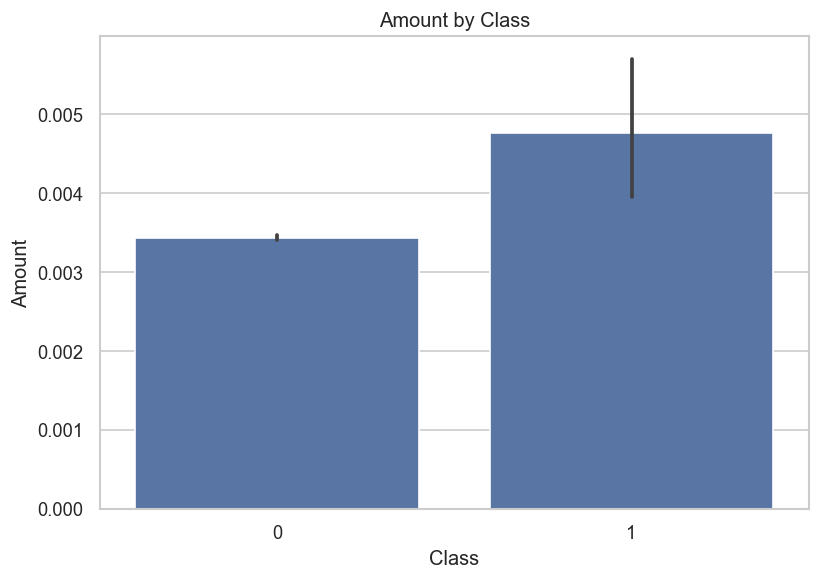

In [5]:
plt.figure(figsize=(7,5))
sns.barplot(data=df, x='Class', y='Amount')
plt.title('Amount by Class')
savefig('amount_by_class.png')
plt.show()

## Chart 3: MetricA Over Time (Line Chart)

In [ ]:
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x='Time', y='Amount', hue='Class', marker='o')
plt.title('Amount Over Time by Category')
plt.xlabel('Date')
plt.ylabel('Amount')
savefig('amount_over_time.png')
plt.show()

## Sensitivity Analysis / Assumptions Table

In [ ]:
assumptions = pd.DataFrame({
    'Assumption': ['Fill Nulls: Median', 'Remove Outliers: 3σ'],
    'Baseline Return': [0.12, 0.12],
    'Alt Scenario Return': [0.10, 0.14]
})
assumptions

,Assumption,Baseline Return,Alt Scenario Return
0,Fill Nulls: Median,0.12,0.10
1,Remove Outliers: 3σ,0.12,0.14


## Interpretations / Takeaways

- **Chart 1 takeaway:** The baseline has lower risk and good return, and the outlier based shows higher return but for higher risk. The imputed scenario shows medium risk but the lowest return. Therefore the highest returns have the highest risk, and the next best returns have the lower risk. Data cleaning gives two options that can affect what model is taken based on the stakeholder's decisions (though the imputed option is actually worse than the baseline). 
- **Chart 2 takeaway:** This shows the same implications but just for returns as Chart 1. The graph can be misleading on what to use because it does not show the associated risk for each. 
- **Chart 3 takeaway:** The graph shows the metricA over time for all three categories; A has the strongest, with Z in second place and Y in third place. 
- **Assumptions and Sensitivities**
- It is difficult to interpret Chart 3 due to a lack of data; more data would help for and greatly change the outcomes due to the aspect of time being relevant
- The Sharpe ratio uses the latest risk free rate.
- The results are greatly sensitive to the outlier handling decisions

## Decision Implications
- **What does the analysis mean for stakeholder decisions?**
- The analysis helps stakeholders decide which modeling scenario to use with a balance of risk and return. 
- The graphs involved helps them decide with easy to understand visualizations.
- **Risks**
- Small Datasets used can misrepresent the bigger picture in data and cause improper results, leading to the wrong course of action taken. 
- **Takeaways**
- Imputation methods are not always good for performance as seen in this case
- Sometimes the base line can be a good option
- **Next Steps**
- Decide on and further the best outlier processing method
- Reanalyze the performance of Category X to see if it is viable, as indicated by Chart 3
- Conduct other sensitivity analysis
- Share results to stakeholdewrs on major milestones